# $\text{UF}_{2,3}$ Demo: Outer Hyperparameter Optimization

This jupyter notebook demonstrates how radial cutoffs (outer) hyperparameters can be optimized using a signle HDF5 feature file generated using a very large 2-body and 3-body cutoff

In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from uf3.data import io
from uf3.data import geometry
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import process
from uf3.regression import least_squares
from uf3.regression.optimize import (get_bspline_config, 
                               get_lower_cutoffs, 
                               get_columns_to_drop_2b, 
                               get_columns_to_drop_3b)

**Inputs**
- ```w-14.xyz``` Contains the training data. Available at [qmml.org](https://qmml.org/datasets.html)
- ```training_idx.txt``` Contains the training keys. Included for reproducibility purposes

In [4]:
#System Defination
element_list = ['W']
degree = 3

chemical_system = composition.ChemicalSystem(element_list=element_list, degree=degree)

When creating HDF5 file for outer hyperparameter optimization, we **recommend** using the ```get_bspline_config``` function for constructing the ```bspline``` object. The current version is only tested for ```leading_trim=0``` and ```trailing_trim=3```.

In [5]:
rmin_2b = 0 #Min of radial cutoff for 2-body
rmin_3b = 1.6 #Min of radial cutoff for 2-body

knot_spacing_2b = 0.5 #spacing between consecutive knots for 2-body
knot_spacing_3b = 0.8 #spacing between consecutive knots for 3-body

rmax_2b = 8 #Cutoff 2-body

rmax_3b = 5.6 #Cutoff 3-body. If A-B-C are the interacting bodies with A as the central atom. Then rmax_3b is
                #maximum possible distance between A-B (or A-C).
                #rmax_3b = Max dist(A,B) = Max dist(A,C) = Max dist(B,C)/2.

bspline_config = get_bspline_config(chemical_system=chemical_system,
                                    rmin_2b=rmin_2b,
                                    rmin_3b=rmin_3b,
                                    rmax_2b=rmax_2b,
                                    rmax_3b=rmax_3b,
                                    knot_spacing_2b=knot_spacing_2b,
                                    knot_spacing_3b=knot_spacing_3b,
                                    leading_trim=0,trailing_trim=3)

In [6]:
bspline_config.knots_map

{('W',
  'W'): array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5,
        5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8. , 8. , 8. ]),
 ('W',
  'W',
  'W'): [array([1.6, 1.6, 1.6, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 5.6, 5.6, 5.6]), array([1.6, 1.6, 1.6, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 5.6, 5.6, 5.6]), array([ 1.6,  1.6,  1.6,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,
          8. ,  8.8,  9.6, 10.4, 11.2, 11.2, 11.2, 11.2])]}

# Load training keys

# Load data

In [7]:
example_directory = os.getcwd()
data_filename = os.path.join(example_directory, "w-14.xyz")

In [8]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_trajectory(data_filename,
                                           prefix='dft')
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


# Compute energy and force features
This is the most expensive step. For demonstration purpose we will only featurize 50 entries. For reproducibility, ```sample_training_id.txt``` contain list of integers corresponding to entries to use for training.

In [9]:
with open(os.path.join(example_directory, "sample_training_id_radial_cutoff_opt.txt"), "r") as f:
    training_50 = [int(idx) for idx in f.read().splitlines()]

In [10]:
filename = "df_features.h5"
table_template = "features_{}"

In [11]:
n_cores = 30
representation = process.BasisFeaturizer(bspline_config)
client = ProcessPoolExecutor(max_workers=n_cores)

In [12]:
representation.batched_to_hdf(filename,
                              df_data.iloc[training_50],
                              client,
                              n_jobs = n_cores,
                              batch_size=5,
                              progress='bar',
                              table_template=table_template)

Once the HDF5 feature file is genererated, use ```get_lower_cutoffs``` function to get all the possible cutoff values for ```rmax_2b``` and ```rmax_3b```.

In [13]:
lower_cutoffs = get_lower_cutoffs(original_bspline_config=bspline_config)
lower_rmax_2b, lower_rmax_3b = lower_cutoffs["lower_rmax_2b"], lower_cutoffs["lower_rmax_3b"]

In [14]:
lower_rmax_2b

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. , 7.5, 8. ])

**Remember** that if A-B-C are the interacting bodies with A as the central atom, then rmax_3b_poss is a list of maximum possible distances between A-B (or A-C). rmax_3b = Max dist(A,B) = Max dist(A,C) = Max dist(B,C)/2.

In [15]:
lower_rmax_3b

array([2.4, 3.2, 4. , 4.8, 5.6])

Let's make a list of outer hyperparameter.

Generally the cutoff of 3-body interaction (maximum side length of the triangle) is less than or euqal to 2-body cutoff.

We will first make a ```meshgrid``` out of ```lower_rmax_2b``` and ```lower_rmax_3b```, and then apply the above condition.

**Note** for the current implementation to work it is not necessary to follow the above condition 

In [16]:
lower_rmax_3b, lower_rmax_2b = np.meshgrid(lower_rmax_3b, lower_rmax_2b)

lower_rmax_3b, lower_rmax_2b = lower_rmax_3b.flatten(), lower_rmax_2b.flatten()

In [17]:
outer_hp = []
                                        
for i in range(lower_rmax_2b.shape[0]):
    if lower_rmax_2b[i]>=2*lower_rmax_3b[i]:
        outer_hp.append([lower_rmax_2b[i],lower_rmax_3b[i]])
outer_hp

[[5.0, 2.4],
 [5.5, 2.4],
 [6.0, 2.4],
 [6.5, 2.4],
 [6.5, 3.2],
 [7.0, 2.4],
 [7.0, 3.2],
 [7.5, 2.4],
 [7.5, 3.2],
 [8.0, 2.4],
 [8.0, 3.2],
 [8.0, 4.0]]

As an example let's fit a model with ```rmax_2b = 7.0```, and ```rmax_3b = 3.0``` with no regularization and energy force weight =1

In [18]:
rmax_2b = outer_hp[3][0]
rmax_3b = outer_hp[3][1]

bspline_config_lower_cutoff = get_bspline_config(chemical_system=chemical_system,
                                                 rmin_2b=rmin_2b,
                                                 rmin_3b=rmin_3b,
                                                 rmax_2b=rmax_2b,
                                                 rmax_3b=rmax_3b,
                                                 knot_spacing_2b=knot_spacing_2b,
                                                 knot_spacing_3b=knot_spacing_3b,
                                                 leading_trim=0,trailing_trim=3)

bspline_config_lower_cutoff.knots_map

{('W',
  'W'): array([0. , 0. , 0. , 0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5,
        5. , 5.5, 6. , 6.5, 6.5, 6.5, 6.5]),
 ('W', 'W', 'W'): [array([1.6, 1.6, 1.6, 1.6, 2.4, 2.4, 2.4, 2.4]),
  array([1.6, 1.6, 1.6, 1.6, 2.4, 2.4, 2.4, 2.4]),
  array([1.6, 1.6, 1.6, 1.6, 2.4, 3.2, 4. , 4.8, 4.8, 4.8, 4.8])]}

We need to know what columns to drop from the generated HDF5 file, so that the features correspond to cutoffs of ```rmax_2b = 7```, and ```rmax_3b = 3.0```

In [19]:
columns_to_drop_2b = get_columns_to_drop_2b(original_bspline_config=bspline_config,
                                         modify_2b_cutoff=rmax_2b,
                                         knot_spacing_2b=knot_spacing_2b)

columns_to_drop_3b = get_columns_to_drop_3b(original_bspline_config=bspline_config,
                                            modify_3b_cutoff=rmax_3b,
                                            knot_spacing_3b=knot_spacing_3b)

columns_to_drop = columns_to_drop_2b
columns_to_drop.extend(columns_to_drop_3b)

In [20]:
regularizer = bspline_config_lower_cutoff.get_regularization_matrix(ridge_1b=0,
                                                                    ridge_2b=0.0,
                                                                    ridge_3b=0)

model = least_squares.WeightedLinearModel(bspline_config_lower_cutoff, regularizer=regularizer)

In [21]:
model.fit_from_file(filename="df_features.h5",
                    subset=df_data.iloc[training_50].index,
                    weight=1,
                    batch_size=10,
                    energy_key="energy", 
                    progress="bar",
                    drop_columns=columns_to_drop)

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
y_e, p_e, y_f, p_f, rmse_e, rmse_f = model.batched_predict(filename="df_features.h5",
                                                           keys=df_data.iloc[training_50].index,
                                                          drop_columns=columns_to_drop)

RMSE (energy): 0.019
RMSE (forces): 0.514


Next we will create 3-folds out of the 50 randomly generated structures

In [23]:
df_folds = [i for i in np.array_split(df_data.iloc[training_50],3)]

Now we will fit models for all values in ```outer_hp``` and perform 3-fold CV.

For demonstration we are not optimizing **inner hyperparameters** i.e regularizers

In [24]:
results = []
cv_fold = 3

for i in outer_hp:
    rmax_2b = i[0]
    rmax_3b = i[1]
    data = [rmax_2b,rmax_3b]
    print(rmax_2b,rmax_3b)
    bspline_config_lower_cutoff = get_bspline_config(chemical_system=chemical_system,
                                                     rmin_2b=rmin_2b,
                                                     rmin_3b=rmin_3b,
                                                     rmax_2b=rmax_2b,
                                                     rmax_3b=rmax_3b,
                                                     knot_spacing_2b=knot_spacing_2b,
                                                     knot_spacing_3b=knot_spacing_3b,
                                                     leading_trim=0,trailing_trim=3)
    
    columns_to_drop_2b = get_columns_to_drop_2b(original_bspline_config=bspline_config,
                                                modify_2b_cutoff=rmax_2b,
                                                knot_spacing_2b=knot_spacing_2b)

    columns_to_drop_3b = get_columns_to_drop_3b(original_bspline_config=bspline_config,
                                                modify_3b_cutoff=rmax_3b,
                                                knot_spacing_3b=knot_spacing_3b)
    
    columns_to_drop = columns_to_drop_2b
    columns_to_drop.extend(columns_to_drop_3b)
    
    for hold_out_fold in range(0,cv_fold):
        df_train_data = [df_folds[j].copy() for j in range(len(df_folds)) if j!=hold_out_fold]
        df_valid_data = df_folds[hold_out_fold]
        
        df_train_data = pd.concat(df_train_data)
        
        training_keys = list(df_train_data.index)
        validation_keys = list(df_valid_data.index)
        
        regularizer = bspline_config_lower_cutoff.get_regularization_matrix(ridge_1b=0,
                                                                    ridge_2b=0.0,
                                                                    ridge_3b=0)

        model = least_squares.WeightedLinearModel(bspline_config_lower_cutoff, regularizer=regularizer)
        
        model.fit_from_file(filename="df_features.h5",
                            subset=training_keys,
                            weight=1,
                            batch_size=100,
                            energy_key="energy", 
                            progress=None,
                            drop_columns=columns_to_drop)
        
        yt_e, pt_e, yt_f, pt_f, rmset_e, rmset_f = model.batched_predict(filename="df_features.h5",
                                                                         keys=training_keys,
                                                                         drop_columns=columns_to_drop)
        
        yv_e, pv_e, yv_f, pv_f, rmsev_e, rmsev_f = model.batched_predict(filename="df_features.h5",
                                                                         keys=validation_keys,
                                                                         drop_columns=columns_to_drop)
        if hold_out_fold ==0:                                                   
            errors = np.array([rmset_e,rmset_f,rmsev_e,rmsev_f])     
        else:                                                                   
            errors = errors + np.array([rmset_e,rmset_f,rmsev_e,rmsev_f])
            
    errors = errors/cv_fold
    data.extend(list(errors))
    results.append(data)

5.0 2.4
RMSE (energy): 0.023
RMSE (forces): 0.516
RMSE (energy): 0.031
RMSE (forces): 0.445
RMSE (energy): 0.024
RMSE (forces): 0.475
RMSE (energy): 0.031
RMSE (forces): 0.625
RMSE (energy): 0.028
RMSE (forces): 0.468
RMSE (energy): 0.030
RMSE (forces): 0.411
5.5 2.4
RMSE (energy): 0.018
RMSE (forces): 0.551
RMSE (energy): 0.139
RMSE (forces): 0.482
RMSE (energy): 0.023
RMSE (forces): 0.514
RMSE (energy): 0.029
RMSE (forces): 0.682
RMSE (energy): 0.026
RMSE (forces): 0.539
RMSE (energy): 0.035
RMSE (forces): 0.496
6.0 2.4
RMSE (energy): 0.018
RMSE (forces): 0.554
RMSE (energy): 0.142
RMSE (forces): 0.483
RMSE (energy): 0.020
RMSE (forces): 0.609
RMSE (energy): 0.031
RMSE (forces): 0.953
RMSE (energy): 0.024
RMSE (forces): 0.523
RMSE (energy): 0.025
RMSE (forces): 0.467
6.5 2.4
RMSE (energy): 0.017
RMSE (forces): 0.649
RMSE (energy): 0.072
RMSE (forces): 0.481
RMSE (energy): 0.018
RMSE (forces): 0.447
RMSE (energy): 0.026
RMSE (forces): 0.517
RMSE (energy): 0.018
RMSE (forces): 0.562
RM

In [25]:
df_result = pd.DataFrame(results,columns=["rmax_2b","rmax_3b","training_error_energy","traininig_error_force",
                                         "validation_error_energy","validation_error_force"])
df_result

,rmax_2b,rmax_3b,training_error_energy,traininig_error_force,validation_error_energy,validation_error_force
0,5.0,2.4,2.484099e-02,0.486508,0.030578,0.493691
1,5.5,2.4,2.224946e-02,0.534941,0.067506,0.553128
2,6.0,2.4,2.064678e-02,0.561963,0.065657,0.634486
3,6.5,2.4,1.762321e-02,0.552773,0.047054,0.463623
4,6.5,3.2,7.721066e-03,3.091893,0.213116,7.312382
5,7.0,2.4,1.628599e-02,0.535050,0.042964,0.507692
6,7.0,3.2,6.207416e-03,3.314830,0.226185,6.461710
7,7.5,2.4,1.546699e-02,0.477571,0.099653,0.536610
8,7.5,3.2,6.168754e-03,3.064264,0.175586,4.017568
9,8.0,2.4,1.535426e-02,0.463413,0.108616,0.524774


In [26]:
df_result.sort_values(by=["rmax_2b","rmax_3b"],inplace=True)

Text(0.5, 0, 'Model Complexity - 2B cutoff radius ($\\AA$)')

<Figure size 640x480 with 0 Axes>

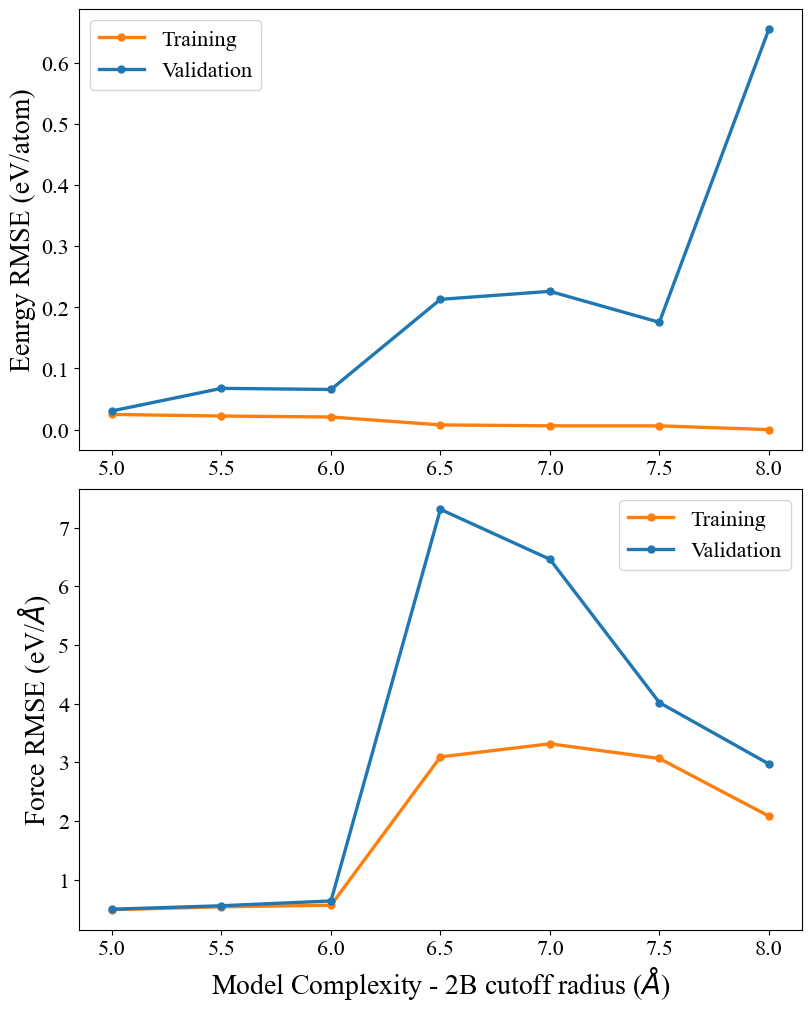

In [27]:
df_result.sort_values(by="rmax_2b",inplace=True)
plt.clf()
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.subplots_adjust(left=0.15,bottom=0.07,right=0.99,top=0.99,hspace=0.05)
fig, axs = plt.subplots(2,1,figsize=(8,10),constrained_layout = True)

energy_train_error = []
energy_valid_error = []

force_train_error = []
force_valid_error = []

cutoff_2b = df_result["rmax_2b"].unique()
for i in cutoff_2b:
    df_temp = df_result.loc[df_result["rmax_2b"]==i].copy()
    df_temp.sort_values(by="training_error_energy",inplace=True)
    energy_train_error.append(df_temp["training_error_energy"].to_numpy()[0])
    energy_valid_error.append(df_temp["validation_error_energy"].to_numpy()[0])
    
    force_train_error.append(df_temp["traininig_error_force"].to_numpy()[0])
    force_valid_error.append(df_temp["validation_error_force"].to_numpy()[0])

axs[0].plot(cutoff_2b,energy_train_error,'.-',color="tab:orange",lw=2.4,ms=10,label="Training")
axs[0].plot(cutoff_2b,energy_valid_error,'.-',color="tab:blue",lw=2.4,ms=10,label="Validation")
axs[0].set_ylabel("Eenrgy RMSE (eV/atom)",fontsize=20)
axs[0].legend()

axs[1].plot(cutoff_2b,force_train_error,'.-',color="tab:orange",lw=2.4,ms=10,label="Training")
axs[1].plot(cutoff_2b,force_valid_error,'.-',color="tab:blue",lw=2.4,ms=10,label="Validation")
axs[1].set_ylabel(r"Force RMSE (eV/$\AA$)",fontsize=20)
axs[1].legend()
axs[1].set_xlabel(r"Model Complexity - 2B cutoff radius ($\AA$)",fontsize=20)

Text(0.5, 0, 'Model Complexity - 3B cutoff radius ($\\AA$)')

<Figure size 640x480 with 0 Axes>

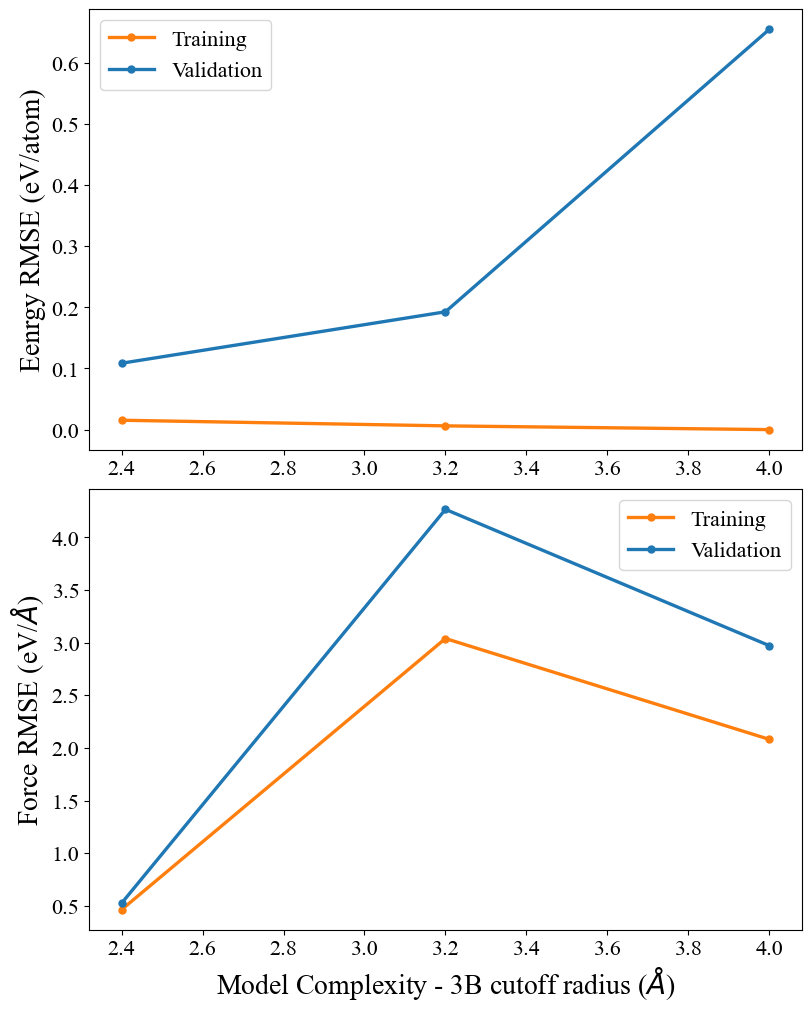

In [28]:
df_result.sort_values(by="rmax_3b",inplace=True)
plt.clf()
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.subplots_adjust(left=0.15,bottom=0.07,right=0.99,top=0.99,hspace=0.05)
fig, axs = plt.subplots(2,1,figsize=(8,10),constrained_layout = True)

energy_train_error = []
energy_valid_error = []

force_train_error = []
force_valid_error = []

cutoff_3b = df_result["rmax_3b"].unique()
for i in cutoff_3b:
    df_temp = df_result.loc[df_result["rmax_3b"]==i].copy()
    df_temp.sort_values(by="training_error_energy",inplace=True)
    energy_train_error.append(df_temp["training_error_energy"].to_numpy()[0])
    energy_valid_error.append(df_temp["validation_error_energy"].to_numpy()[0])
    
    force_train_error.append(df_temp["traininig_error_force"].to_numpy()[0])
    force_valid_error.append(df_temp["validation_error_force"].to_numpy()[0])

axs[0].plot(cutoff_3b,energy_train_error,'.-',color="tab:orange",lw=2.4,ms=10,label="Training")
axs[0].plot(cutoff_3b,energy_valid_error,'.-',color="tab:blue",lw=2.4,ms=10,label="Validation")
axs[0].set_ylabel("Eenrgy RMSE (eV/atom)",fontsize=20)
axs[0].legend()

axs[1].plot(cutoff_3b,force_train_error,'.-',color="tab:orange",lw=2.4,ms=10,label="Training")
axs[1].plot(cutoff_3b,force_valid_error,'.-',color="tab:blue",lw=2.4,ms=10,label="Validation")
axs[1].set_ylabel(r"Force RMSE (eV/$\AA$)",fontsize=20)
axs[1].legend()
axs[1].set_xlabel(r"Model Complexity - 3B cutoff radius ($\AA$)",fontsize=20)